In [1]:
import os

In [2]:
os.chdir("../scripts")

In [3]:
from load_data import load_data

In [4]:
data = load_data()

/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-3/scripts/load_data.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../datas/MachineLearningRating_v3.txt', delimiter='|')


## Data Preparation

In [5]:
import pandas as pd

data = data.dropna(subset=['TotalClaims', 'TotalPremium'])

# Fill missing values with a constant value
data.fillna(-1, inplace=True)

# Convert TransactionMonth to datetime and extract year and month
data['TransactionMonth'] = pd.to_datetime(data['TransactionMonth'], errors='coerce')
data['TransactionYear'] = data['TransactionMonth'].dt.year
data['TransactionMonth'] = data['TransactionMonth'].dt.month

# Create new features if relevant
data['Margin'] = data['TotalPremium'] - data['TotalClaims']

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Province', 'Gender', 'VehicleType', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType'])

# Ensure all columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Drop any remaining non-numeric columns
data = data.dropna(axis=1, how='any')


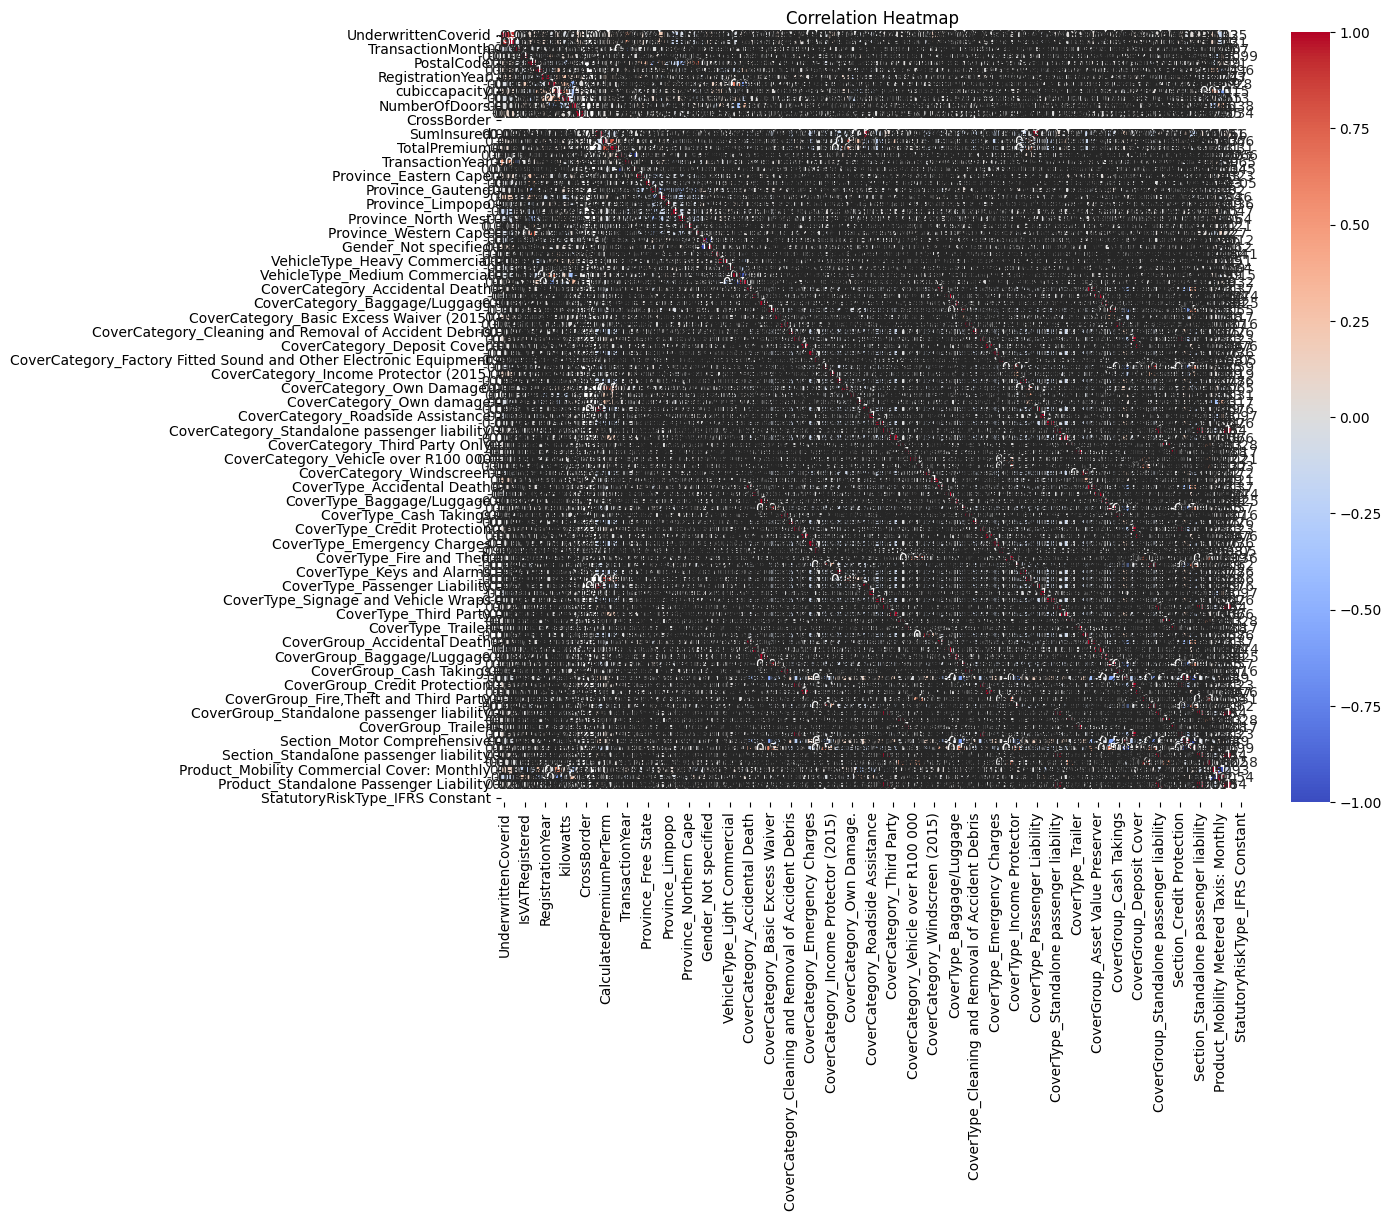

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = data.drop(columns=['TotalPremium', 'TotalClaims'])
y = data['TotalClaims']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure all columns are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Modeling Techniques

## 1. Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr}, R2: {r2_lr}")

Linear Regression - MSE: 10376.428677693315, R2: 0.998145893365056


## 2. Random Forests

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf}, R2: {r2_rf}")

Random Forest - MSE: 2579.5712021747436, R2: 0.9995390706928343


## 3. XGBoost

In [9]:
import xgboost as xgb

# Train the model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MSE: {mse_xgb}, R2: {r2_xgb}")

XGBoost - MSE: 3092676.572109271, R2: 0.4473867329314575


## Model Evaluation

In [10]:
from sklearn.metrics import mean_absolute_error

# Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr}")

# Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf}")

# XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb}")

Linear Regression - MAE: 47.65631695797839
Random Forest - MAE: 0.7503881983354518
XGBoost - MAE: 49.81320143572176


## Feature Importance Analysis


In [11]:
from sklearn.preprocessing import OneHotEncoder

# Example preprocessing for categorical features
categorical_cols = X_train.select_dtypes(include=['object']).columns

# One-hot encoding for training data
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)

# Ensure the test set has the same columns as the training set
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [12]:
X_train_encoded = X_train_encoded.astype('float64')
X_test_encoded = X_test_encoded.astype('float64')


In [16]:
assert X_train_encoded.columns.equals(X_test_encoded.columns), "Column mismatch between train and test!"


In [13]:
print(X_train_encoded.dtypes)
print(X_test_encoded.dtypes)


UnderwrittenCoverid                           float64
PolicyID                                      float64
TransactionMonth                              float64
IsVATRegistered                               float64
PostalCode                                    float64
                                               ...   
Product_Mobility Commercial Cover: Monthly    float64
Product_Mobility Metered Taxis: Monthly       float64
Product_Standalone Passenger Liability        float64
StatutoryClass_Commercial                     float64
StatutoryRiskType_IFRS Constant               float64
Length: 107, dtype: object
UnderwrittenCoverid                           float64
PolicyID                                      float64
TransactionMonth                              float64
IsVATRegistered                               float64
PostalCode                                    float64
                                               ...   
Product_Mobility Commercial Cover: Monthly    float64
P

100%|===================| 122958/123486 [03:01<00:00]        

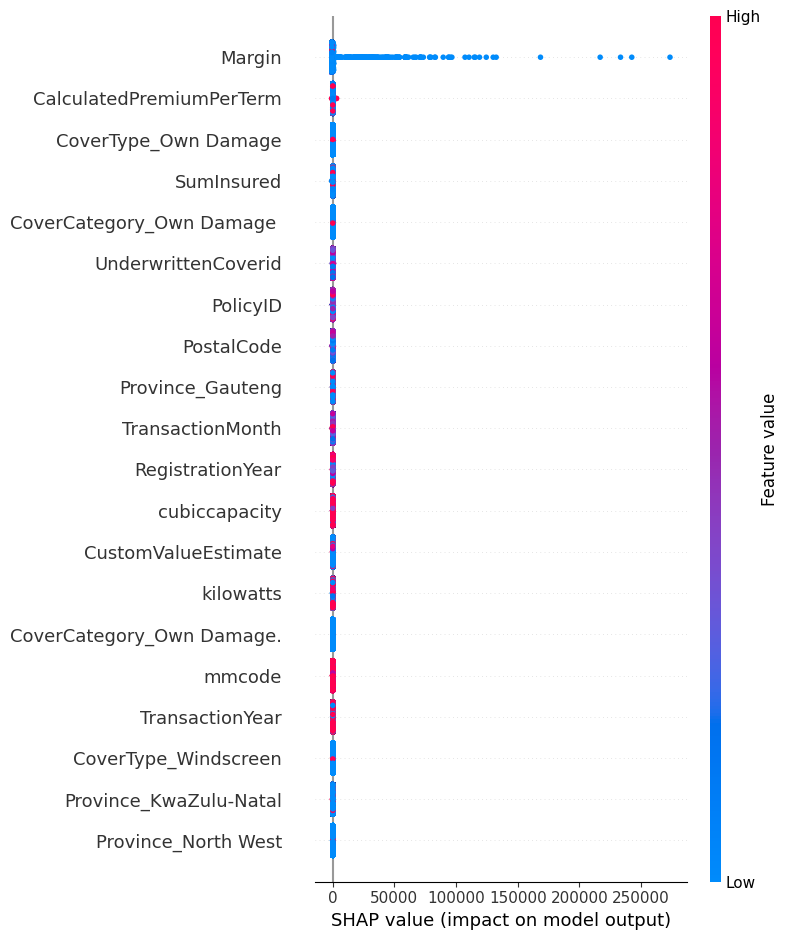

In [17]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(rf_model, X_train_encoded)
shap_values = explainer(X_test_encoded, check_additivity=False)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_encoded)



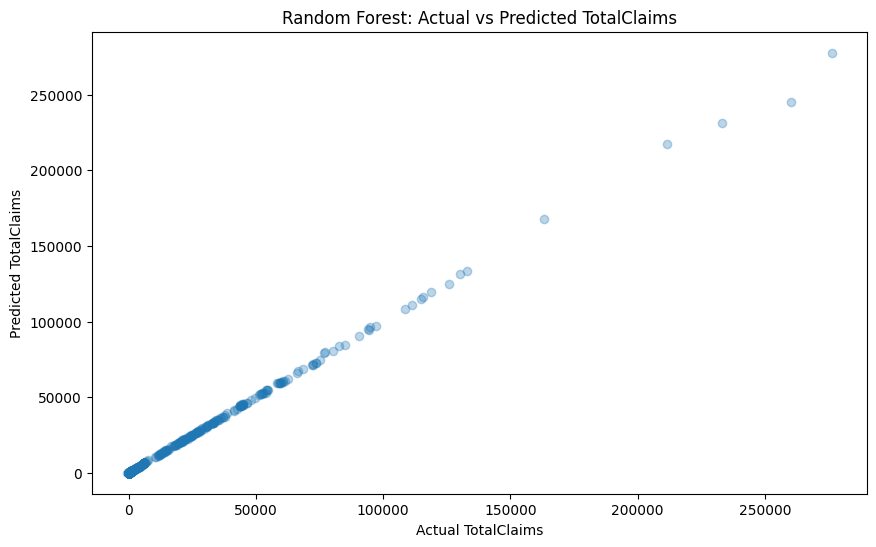

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel('Actual TotalClaims')
plt.ylabel('Predicted TotalClaims')
plt.title('Random Forest: Actual vs Predicted TotalClaims')
plt.show()

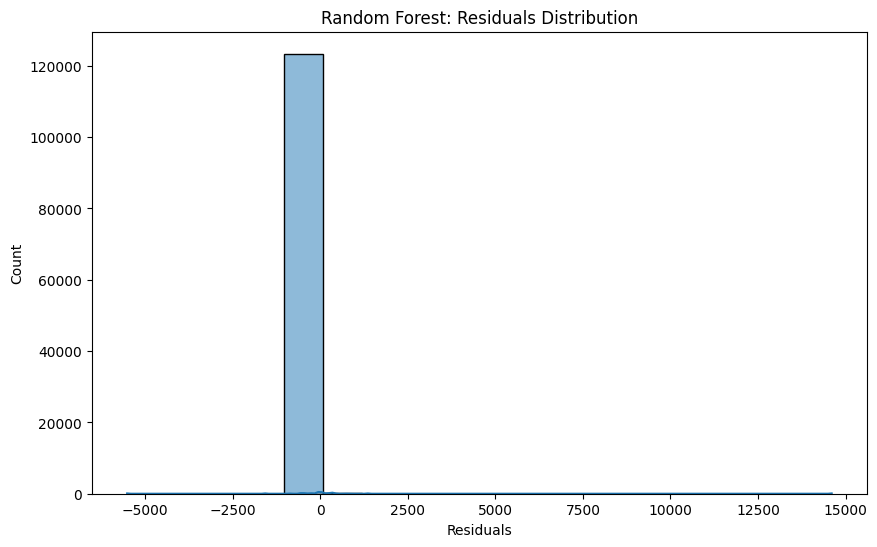

In [20]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Random Forest: Residuals Distribution')
plt.show()